In [1]:
import medleydb as mdb
import librosa
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import librosa.display
import pandas as pd
import IPython.display as ipd
import os
import random
from os import path
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import yaml


%load_ext line_profiler

HOME_PATH = path.expanduser("~")
UNSEEN_PATH = os.path.join(HOME_PATH, "data", "es_data",)
DATA_PATH = path.join(HOME_PATH, "data", "preprocessed")
MIX_PATH = path.join(HOME_PATH, "data", "medleydb", "medleydb", "Audio")
CACHE_PATH = path.join(HOME_PATH, "data", "cache")
SLAKH_PATH = path.join(HOME_PATH, "data", "slakh", "test")
track_metadata = path.join(SLAKH_PATH, "%s", "metadata.yaml")
track_stem = path.join(SLAKH_PATH, "%s", "stems", "%s.wav")

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Ändra till detta i en paketstruktur
# DATA_PATH = path.join(path.dirname(__file__), 'data', 'preprocessed')

# Based off of OpenMICs taxonomy discussions and the MedleyDB taxonomy yaml
OPENMIC_TO_MEDLEY = {
    "drums": [
        "drum set",
        "drum machine",
        "kick drum",
        "cymbal",
        "conga",
        "snare drum",
        "bass drum",
        "high hat",
        "bongo",
    ],
    "bass": ["electric bass", "double bass"],
    "guitar": [
        "distorted electric guitar",
        "clean electric guitar",
        "acoustic guitar",
        "lap steel guitar",
    ],
    "voice": [
        "male singer",
        "female singer",
        "male speaker",
        "female speaker",
        "male rapper",
        "female rapper",
        "beatboxing",
        "vocalists",
        "choir",
        "male screamer",
        "female screamer",
    ],
    "piano": ["piano", "tack piano", "electric piano"],
}

others = mdb.get_valid_instrument_labels()
for k, v in OPENMIC_TO_MEDLEY.items():
    for i in v:
        others.remove(i)
others = list(others)

OPENMIC_TO_MEDLEY["other"] = others

print(OPENMIC_TO_MEDLEY)

INSTRUMENTS = OPENMIC_TO_MEDLEY.keys()
INSTRUMENT_INDEX = {key: i for i, (key, _) in enumerate(OPENMIC_TO_MEDLEY.items())}
MEDLEY_TO_OPENMIC = {v: k for k, v_list in OPENMIC_TO_MEDLEY.items() for v in v_list}
MEDLEY_TO_INDEX = {k: INSTRUMENT_INDEX[v] for k, v in MEDLEY_TO_OPENMIC.items()}
REV_INSTRUMENT_INDEX = {v: k for k, v in INSTRUMENT_INDEX.items()}
NUM_LABELS = len(INSTRUMENTS)

def find_slakh_instrument_classes():
    instruments = set() 
    count = 0
    for track in tracks:
        print(count, end="\r")
        with open(track_metadata % track) as f:
            metadata = yaml.safe_load(f)
        for s, v in metadata["stems"].items():
            instruments.add(v["inst_class"])
        count += 1
    print(instruments)
    return instruments
    

# Consider using to_lowercase on slakh
LABELS_TO_SLAKH = {
    "drums": ["Drums",],
    "bass": ["Bass"],
    "guitar": ["Guitar",],
    "voice": [],
    "piano": ["Piano"],
}

#Found using find_slakh_instruments_classes
SLAKH_INSTRUMENTS = {
    "Drums",
    "Synth Lead",
    "Guitar",
    "Reed",
    "Strings",
    "Piano",
    "Brass",
    "Ethnic",
    "Sound effects",
    "Synth Pad",
    "Pipe",
    "Organ",
    "Percussive",
    "Sound Effects",
    "Bass",
    "Chromatic Percussion",
    "Strings (continued)",
}

others = SLAKH_INSTRUMENTS

for k, v in LABELS_TO_SLAKH.items():
    for i in v:
        others.remove(i)

LABELS_TO_SLAKH["other"] = others

SLAKH_TO_LABELS = {v: k for k, v_list in LABELS_TO_SLAKH.items() for v in v_list}

def play_medley_audio(track):
    track_id = load_track(track).mix_path
    samples, sample_rate = librosa.load(track_id)
    ipd.display(ipd.Audio(samples, rate=sample_rate))


def play_audio(track):
    homedir = os.path.expanduser("~")
    path = os.path.join(homedir, "data/es_data", track)
    samples, sample_rate = librosa.load(path)
    ipd.display(ipd.Audio(samples, rate=sample_rate))


def play_audio_from_waveform(track, sr):
    ipd.display(ipd.Audio(track, rate=sr))


def load_track(track_id):
    t_gen = mdb.load_multitracks([track_id])
    return next(t_gen)

/home/carlnys/data/medleydb/medleydb/__init__.py:68: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  INST_TAXONOMY = yaml.load(fhandle)
/home/carlnys/data/medleydb/medleydb/__init__.py:76: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  MIXING_COEFFICIENTS = yaml.load(fhandle)


{'drums': ['drum set', 'drum machine', 'kick drum', 'cymbal', 'conga', 'snare drum', 'bass drum', 'high hat', 'bongo'], 'bass': ['electric bass', 'double bass'], 'guitar': ['distorted electric guitar', 'clean electric guitar', 'acoustic guitar', 'lap steel guitar'], 'voice': ['male singer', 'female singer', 'male speaker', 'female speaker', 'male rapper', 'female rapper', 'beatboxing', 'vocalists', 'choir', 'male screamer', 'female screamer'], 'piano': ['piano', 'tack piano', 'electric piano'], 'other': ['trombone section', 'bandoneon', 'bamboo flute', 'flute section', 'cornet', 'marimba', 'oud', 'viola', 'tabla', 'fx/processed sound', 'liuqin', 'gu', 'mandolin', 'soprano saxophone', 'shaker', 'violin', 'panpipes', 'english horn', 'piccolo', 'chimes', 'whistle', 'xylophone', 'harp', 'ukulele', 'harpsichord', 'euphonium', 'claps', 'concertina', 'cowbell', 'harmonium', 'bass clarinet', 'timpani', 'harmonica', 'baritone saxophone', 'sitar', 'clarinet section', 'alto saxophone', 'synthesiz

In [2]:
def create_train_val_test_split(tracks, test_size=0.2, val_size=0.2):
    X = []
    Y = []

    for t in tracks:
        instruments = {
            MEDLEY_TO_OPENMIC[i]
            for i in t.stem_instruments
            if i in MEDLEY_TO_OPENMIC.keys()
        }
        #
        # intersection = instruments.intersection(INSTRUMENTS)
        #
        # if "other" in intersection and len(intersection) < 3:
        #    continue
        # elif len(intersection) < 2:
        #    continue
        #
        X.append(t)
        Y.append(list(instruments))

    mlb = MultiLabelBinarizer(list(INSTRUMENTS))
    Y = mlb.fit_transform(Y)
    X = np.array(X)

    test_train = MultilabelStratifiedShuffleSplit(
        n_splits=2, test_size=test_size, random_state=0
    )

    for train_index, test_index in test_train.split(X, Y):
        X_train, test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        break

    train_val = MultilabelStratifiedShuffleSplit(
        n_splits=2, test_size=val_size, random_state=0
    )

    for train_index, test_index in train_val.split(X_train, Y_train):
        train, val = X_train[train_index], X_train[test_index]
        train_labels, val_labels = Y_train[train_index], Y_train[test_index]
        break

    print("Training sample length:", train.shape[0])
    print("Distribution:", np.sum(train_labels, axis=0))
    print("Validation sample length:", val.shape[0])
    print("Distribution:", np.sum(val_labels, axis=0))
    print("Test sample length", test.shape[0])
    print("Distribution:", np.sum(Y_test, axis=0))

    return train, val, test


# Example {"guitar": [stem_1.wav, ..., stem_n.wav], "bass": [stem_1.wav, ..., stem_n.wav]...}
def mdb_index(tracklist):
    files = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}
    for t in tracklist:
        for k, v in t.stems.items():
            if v.instrument[0] in MEDLEY_TO_OPENMIC.keys():
                instrument = MEDLEY_TO_OPENMIC[v.instrument[0]]
                files[instrument].append(v.audio_path)
    return files


# Example {"ArtistSong" : {"guitar" : [stem_1.wav, stem_2.wav]} }
def mdb_baseline_index(tracklist):
    files = {}
    for t in tracklist:
        for k, v in t.stems.items():
            # help(v)
            if v.instrument[0] in MEDLEY_TO_OPENMIC.keys():
                instrument = MEDLEY_TO_OPENMIC[v.instrument[0]]
                if t.track_id not in files.keys():
                    files[t.track_id] = {k: [] for k, _ in OPENMIC_TO_MEDLEY.items()}
                files[t.track_id][instrument] = files[t.track_id].get(
                    instrument, []
                ) + [v.audio_path]
    return files

def slakh_index(tracks):
    files = {k: [] for k, v in LABELS_TO_SLAKH.items()}
    for track in tracks:
        with open(track_metadata % track) as f:
            metadata = yaml.safe_load(f)
        for stem, v in metadata["stems"].items():
            if v["inst_class"] in SLAKH_TO_LABELS.keys():
                instrument = SLAKH_TO_LABELS[v["inst_class"]]
                stem_path = track_stem % (track, stem)
                if os.path.exists(stem_path):
                    files[instrument].append(stem_path)
    return files 


def slakh_baseline_index(tracks):
    files = {}
    for track in tracks:
        with open(track_metadata % track) as f:
            metadata = yaml.safe_load(f)
        for stem, v in metadata["stems"].items():
            if v["inst_class"] in SLAKH_TO_LABELS.keys():
                instrument = SLAKH_TO_LABELS[v["inst_class"]]
                if track not in files.keys():
                    files[track] = {k: [] for k, _ in LABELS_TO_SLAKH.items()}
                stem_path = track_stem % (track, stem)
                if os.path.exists(stem_path):
                    files[track][instrument] = files[track].get(
                        instrument, []
                    ) + [stem_path]
    return files 

In [91]:
from joblib import Memory

# Creates a cache for function calls with certain parameters and their returns
memory = Memory(CACHE_PATH, verbose=0)
load = memory.cache(librosa.load)
get_duration = memory.cache(librosa.get_duration)

def cache_all_slakh_stems():
    files = slakh_index(slakh_tracks)
    length = 0 
    for k, v in files.items():
        length += len(v)
    count = 0
    for k, v in files.items():
        for f in v:
            w, y, offset = x_y_from_stem(f, spectrogram_params, None)
            print(count, "/", length, end="\r")
            count += 1
            
def x_y_from_stem(f, s_p, offset, song_id, shape):
#def x_y_from_stem(f, s_p, offset):
    num_windows = s_p["num_windows"]
    duration = s_p["duration"]
    spectrogram_len = s_p["spectrogram_len"]
    n_fft = s_p["n_fft"]
    hop_length = s_p["hop_length"]
    n_mels = s_p["n_mels"]
    sr = s_p["sample_rate"]

    if offset is None:
        d = get_duration(filename=f)
        offset = random.randint(0, int(d - duration))

    # Loading and caching the whole stem for less cache misses
    # (MUCH faster than loading and caching snippets)
    waveform, _ = load(f, sr, res_type="kaiser_fast",)

    # Convert offset to samples
    waveform = waveform[sr * offset : sr * offset + int(sr * duration)]
    
    y = librosa.feature.rms(waveform, frame_length=n_fft, hop_length=hop_length) > 0.01
    if shape is None:
        shape = y.shape
    elif shape != y.shape:
        print(song_id)
    
    # x = librosa.feature.melspectrogram(
    #    waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    # )
    # x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
    return waveform, y, offset, shape


def mix(files, s_p, baseline):
    count = 0 
    shape = None
    song_id = ""
    while True:
        xs = []
        ys = []
        paths = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}

        # reformat input to {'guitar' : [stem_1.wav,...], 'bass': [stem_2.wav,...]}
        if baseline:
            song_id, instrument_dict = random.choice(list(files.items()))
            #print(song_id)
            d = None
            for instrument, stems in instrument_dict.items():
                for stem in stems:
                    paths[instrument].append(stem)
        else:
            for instrument, stems in files.items():
                if len(stems) > 0:
                    paths[instrument].append(random.choice(stems))

        offset = None
        # invariant to input type
        for _, path_list in paths.items():
            y = np.zeros((1, s_p["num_windows"]))
            if not baseline:
                offset = None
            for path in path_list:
                #x, _y, offset = x_y_from_stem(path, spectrogram_params, offset)
                x, _y, offset, shape = x_y_from_stem(path, spectrogram_params, offset, song_id, shape)
                y = np.logical_or(y, _y)
                xs.append(x)
            ys.append(y)

        x = np.sum(np.array(xs), axis=0)
        x = librosa.feature.melspectrogram(
            x,
            sr=s_p["sample_rate"],
            n_fft=s_p["n_fft"],
            hop_length=s_p["hop_length"],
            n_mels=s_p["n_mels"],
        )
        x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
        x = np.expand_dims(x, axis=0)
        x -= x.min()
        # Sometimes complete silence and division by 0 
        if x.max() != 0:
            x /= x.max()
        y = np.stack(ys)
        y = y.reshape(y.shape[0], y.shape[2])
        y = y.astype(float)
        #print("yield: ", count % (15*16))
        count += 1
        yield x, y

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import medleydb as mdb
import librosa
import librosa.display
import IPython.display as ipd
import sklearn.metrics as metrics


class MedleyDB(Dataset):
    def __init__(self, files, spectrogram_params, baseline=False, training_data=True):
        self.files = files
        self.baseline = baseline
        self.spectrogram_params = spectrogram_params
        self.training_data = training_data
        self.mixer = mix(self.files, self.spectrogram_params, self.baseline)

    def __getitem__(self, idx):
        return next(self.mixer)

    def __len__(self):
        return 2000 if self.training_data else int(2000*0.2)
        #return 2000 if self.training_data else 2000


# Works fine, but have to rewrite training to account for notion of epochs
# class MedleyDB(torch.utils.data.IterableDataset):
#    def __init__(self, files, spectrogram_params, baseline=False):
#        self.files = files
#        self.baseline = baseline
#        self.spectrogram_params = spectrogram_params
#        self.mixer = mix(self.files, self.spectrogram_params, self.baseline)
#
#    def __iter__(self):
#        return iter(self.mixer)

#cache_all_slakh_stems()


In [4]:
spectrogram_params = {
    "sample_rate": 16000,
    "spectrogram_len": 8.191,
    "n_fft": 1024,
    "hop_length": 512,
    "n_mels": 128,
    "duration": 8.191,
    "num_windows": 256,
}

tracks = mdb.load_all_multitracks(["V1", "V2"])
train, val, test = create_train_val_test_split(tracks, test_size=0.2, val_size=0.2)
slakh_tracks = os.listdir(SLAKH_PATH)
train_paths_slakh = slakh_baseline_index(slakh_tracks)
train_data_slakh = MedleyDB(train_paths_slakh, spectrogram_params, baseline=True)
train_slakh = DataLoader(train_data_slakh, batch_size=1)

train_paths = mdb_baseline_index(train)
train_data = MedleyDB(train_paths, spectrogram_params, baseline=True)
train = DataLoader(train_data, batch_size=1)

/home/carlnys/data/medleydb/medleydb/multitrack.py:368: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


Training sample length: 121
Distribution: [80 78 59 56 54 93]
Validation sample length: 29
Distribution: [20 19 15 14 14 23]
Test sample length 46
Distribution: [26 25 19 18 18 30]


In [30]:
def test_mix(slakh=True):
    if slakh:
        gen = iter(train_slakh)
    else:
        gen = iter(train)
    for i in range(5):
        x, y = next(gen)
        
%lprun -f mix test_mix(True)

NameError: name 'train_slakh' is not defined

In [4]:
def display_spectrogram(s, p):

    librosa.display.specshow(
        s, x_axis="time", y_axis="mel", sr=p["sample_rate"], hop_length=p["hop_length"]
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel-frequency spectrogram")
    plt.tight_layout()
    plt.show()


def test_instrument_activations():
    y_tot = np.zeros((5, 256)).astype(float)
    gen = mix(train_paths, spectrogram_params, True)
    for i in range(1000):
        x, y = next(gen)
        y_tot += y

    y_tot = y_tot.sum(axis=1)
    return y_tot


def test_data_loader(data_loader):
    x, y = next(iter(data_loader))
    s = x.numpy()[0]
    s1 = x.numpy()[1]
    comparison = s1 == s
    equal_arrays = comparison.all()
    print(equal_arrays)
    print(s.shape)
    l = y.numpy()[0]
    l2 = y.numpy()[1]
    print(l2)
    print(l.shape)
    np.set_printoptions(threshold=sys.maxsize)
    print(len(l[0]))
    display_spectrogram(s[0], spectrogram_params)

In [44]:
# Trying to mimic TUT-SED Synthetic 2016 in
# Convolutional Recurrent Neural Networks for
# Polyphonic Sound Event Detection
class CRNN(nn.Module):
    def __init__(self, gru_input, gru_hidden, gru_layers, complx=False):
        super(CRNN, self).__init__()

        self.gru_input = gru_input
        self.gru_hidden = gru_hidden
        self.gru_layers = gru_layers
        self.complx = complx

        # We only pool on the freq. axis
        self.pool_2x1 = nn.MaxPool2d([2, 1])
        self.pool_4x1 = nn.MaxPool2d([4, 1])

        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
        )
        self.conv4_bn = nn.BatchNorm2d(256)

        # now stack -> [batch_size, 256, 1, 256] -> [batch_size, 256*1, 256]

        # (input shape (w.o batch), hidden shape, n_layers, batch_first=True)
        self.gru = nn.GRU(gru_input, gru_hidden, gru_layers, batch_first=True)
        # torch.Size([batch_size, 256, 1, 256])
        if self.complx:
            self.fc1 = nn.Linear(256, 1024*3)
            self.fc2 = nn.Linear(1024*3, 1024)
            self.fc3 = nn.Linear(1024, NUM_LABELS)
        else:
            self.fc = nn.Linear(256, NUM_LABELS)

    def forward(self, x, h):
        assert x.min() >= 0 and x.max() <= 1
        #print(x.shape)
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.pool_4x1(self.conv1_bn(self.conv1(x))))
        #print(x.shape)
        x = F.relu(self.pool_4x1(self.conv2_bn(self.conv2(x))))
        #print(x.shape)
        x = F.relu(self.pool_4x1(self.conv3_bn(self.conv3(x))))
        #print(x.shape)
        x = F.relu(self.pool_2x1(self.conv4_bn(self.conv4(x))))
        #print("After CNN", x.shape)
        # torch.Size([batch_size, 256, 1, 256])
        # (batch x classes x 1 x time) -> (batch x classes x time)
        x = x.view(x.shape[0], 256, 256)
        # Gru expects (batch, seq, feature)
        # The sequence in this case is our time axis
        x = x.permute(0, 2, 1)
        #print("After permute", x.shape)
        x, h = self.gru(x, h)
        #print("After gru", x.shape)
        if self.complx:
            x = F.relu(self.fc1(x))
            #print("Complex FC1", x.shape)
            x = F.relu(self.fc2(x))
            #print("Complex FC2", x.shape)
            x = self.fc3(x)
            #print("Complex FC3", x.shape)
        else:
            x = self.fc(x)
        #print("After fc,", x.shape)
        # (batch_size, seq, num_classes)
        x = x.permute(0, 2, 1)
        #print("After permute back", x.shape)
        return x, h

    def init_hidden(self, batch_size):
        """ Initializes hidden state """
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        # (n_layers, batch, n_hidden)
        h0 = Variable(torch.zeros(self.gru_layers, batch_size, self.gru_hidden)).cuda()
        return h0

In [6]:
def save_state(state, filename="state.pt"):
    torch.save(state, filename)


def train_model(model_name, crnn=False):
    validation_loss_min = sys.maxsize
    train_losses = []
    validation_losses = []
    for epoch in range(1, n_epochs + 1):
        if crnn:
            h = model.init_hidden(batch_size)
            val_h = model.init_hidden(batch_size)
        print("Epoch: {}/{}".format(epoch, n_epochs))
        # keep track of training and validation loss
        train_loss = 0.0
        validation_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train):
            print("Batch: {}/{}".format(batch_idx, num_batches), end="\r")
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.float().cuda(), target.float().cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if crnn:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                h = model.init_hidden(data.shape[0])
                output, h = model(data, h)
            # forward pass: compute predicted outputs by passing inputs to the model
            # print(data.shape)
            else:
                output = model(data)
            # print(output.shape)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss, loss.item is the avarage loss of the batch.
            train_loss += loss.item() * data.size(0)

        ######################
        # validate the model #
        ######################
        model.eval()
        for data, target in validation:
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            if crnn:
                # Detatching hidden state from the computational graph
                # (see truncated back propagation through time) such that
                # the graph doesn't become super big, slowing down computations
                # and exploding the gradient.

                # Note however that the hidden state VALUE will still be inherited
                # We just say that it doesn't depend on previous hidden states
                val_h = model.init_hidden(data.shape[0])
                output, val_h = model(data, val_h)
            else:
                output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            validation_loss += loss.item() * data.size(0)

        # calculate average losses
        train_loss = train_loss / len(train.sampler)
        validation_loss = validation_loss / len(validation.sampler)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        # plot_loss(train_losses, validation_losses)
        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, validation_loss
            )
        )

        # save model if validation loss has decreased
        if validation_loss <= validation_loss_min:
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    validation_loss_min, validation_loss
                )
            )

            state = {
                "model_name": model_name,
                "epoch": epoch + 1,
                "lr": lr,
                "train_losses": train_losses,
                "validation_losses": validation_losses,
                "state_dict": model.state_dict(),
                "best_val_acc": validation_loss,
                "optimizer": optimizer.state_dict(),
            }

            if crnn:
                save_state(state, "%s.pt" % model_name)

            else:
                save_state(state, "%s.pt" % model_name)

            validation_loss_min = validation_loss

    state = {
        "model_name": model_name,
        "epoch": epoch + 1,
        "lr": lr,
        "train_losses": train_losses,
        "validation_losses": validation_losses,
        "state_dict": model.state_dict(),
        "best_val_acc": validation_loss,
        "optimizer": optimizer.state_dict(),
    }

    if crnn:
        save_state(state, "overfit_%s.pt" % model_name)

    else:
        save_state(state, "overfit_%s.pt" % model_name)

In [58]:
from sklearn.metrics import classification_report


def calculate_metrics(scores, predictions, targets):
    cr = classification_report(
        targets, predictions, target_names=list(INSTRUMENTS), output_dict=False
    )

    print(cr)

    cr = classification_report(
        targets, predictions, target_names=list(INSTRUMENTS), output_dict=True
    )
    # f1_macro = metrics.f1_score(targets, predictions, average='macro')
    # f1_micro = metrics.f1_score(targets, predictions, average='micro')
    lrap = metrics.label_ranking_average_precision_score(targets, scores)
    auc_roc_micro = metrics.roc_auc_score(targets, scores, average="micro")
    auc_roc_macro = metrics.roc_auc_score(targets, scores, average="macro")
    print("lrap:", lrap)
    print("AUC-ROC-Macro:", auc_roc_macro)
    print("AUC-ROC-Micro:", auc_roc_micro)
    cr["lrap"] = lrap
    cr["auc_roc_macro"] = auc_roc_macro
    cr["auc_roc_micro"] = auc_roc_micro
    return cr


# REMEMBER TO MANUALLY SIGMOID THE OUTPUTS SINCE THE LOSS DOES THAT FOR US
def test_model(model, crnn=True):
    model.eval()
    # track test loss
    test_loss = 0.0
    # iterate over test data

    labels_total = np.zeros(NUM_LABELS)
    correct_pred = np.zeros(NUM_LABELS)

    labels_total_test = torch.zeros(NUM_LABELS).cuda()
    correct_pred_test = torch.zeros(NUM_LABELS).cuda()

    scores = torch.zeros([0, NUM_LABELS]).cuda()
    predictions = torch.zeros([0, NUM_LABELS]).cuda()
    targets = torch.zeros([0, NUM_LABELS]).cuda()
    
    test = DataLoader(
        test_data,
        batch_size=batch_size,
        num_workers=os.cpu_count(),
        worker_init_fn=_init_fn,
    )
    
    for idx, (data, target) in enumerate(test):
        if gpu_available:
            data, target = data.float().cuda(), target.float().cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        if crnn:
            h = model.init_hidden(data.shape[0])
            output, h = model(data, h)
        else:
            output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class

        # Convert to score and use threshhold 0.5
        output = torch.sigmoid(output)

        pred = (output > 0.5).float()

        scores = torch.cat(
            [scores, output.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )
        predictions = torch.cat(
            [predictions, pred.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )
        targets = torch.cat(
            [targets, target.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )

        # compare predictions to true label
        correct = pred.eq(target.data.view_as(pred))
        # true_positives = np.logical_and(pred.cpu().numpy(), correct.cpu().numpy())
        true_positives = pred * correct

        labels_total_test = labels_total_test + torch.sum(
            target.permute(0, 2, 1).reshape(-1, NUM_LABELS), axis=0
        )
        correct_pred_test = correct_pred_test + torch.sum(
            true_positives.permute(0, 2, 1).reshape(-1, NUM_LABELS), axis=0
        )

        # Go through the batch, aggregate true positives
        # for i in range(target.shape[0]):
        # Elementwise addition

    # average test loss
    test_loss = test_loss / len(test)
    print("Ground truth true positives per class: ", labels_total_test.cpu().numpy())
    print("Predictied true positives per class: ", correct_pred_test.cpu().numpy())
    print("Test Loss: {:.6f}\n".format(test_loss))
    np.set_printoptions(suppress=True)
    return scores.cpu().numpy(), predictions.cpu().numpy(), targets.cpu().numpy()


# scores, predictions, targets = test_model(model, num_batches)
# scores, predictions, targets = test_model(model, num_batches, crnn=True)


def load_model_and_state(file, model, optimizer):
    state = torch.load(file)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    return state


def load_state(model_name):
    return torch.load("%s.pt" % model_name)


def run_tests(model_name, model, optimizer):
    print("=" * 80, "\n")
    state = load_model_and_state("%s.pt" % model_name, model, optimizer)
    print("Running Tests")
    scores, predictions, targets = test_model(model, crnn=True)
    print("=" * 80, "\n")
    print("Calculating Metrics")
    metrics = calculate_metrics(scores, predictions, targets)
    print("=" * 80, "\n")
    print("Saving")
    state["metrics"] = metrics
    save_state(state, "%s.pt" % model_name)
    return state

In [181]:
# Following two functions contain spaghetti code, but should work
def test_x_y_from_stem(f, s_p, offset):
    num_windows = s_p["num_windows"]
    duration = s_p["duration"]
    spectrogram_len = s_p["spectrogram_len"]
    n_fft = s_p["n_fft"]
    hop_length = s_p["hop_length"]
    n_mels = s_p["n_mels"]
    sr = s_p["sample_rate"]

    # Loading and caching the whole stem for less cache misses
    # (MUCH faster than loading and caching snippets)
    _waveform, _ = load(f, sr, res_type="kaiser_fast",)

    # Convert offset to samples
    waveform = _waveform[int(sr * offset) : int(sr * offset) + int(sr * duration)]

    y = librosa.feature.rms(waveform) > 0.01
    x = librosa.feature.melspectrogram(
        waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
    return x, y, _waveform, waveform


def test_mix(files, spectrogram_params, slakh=True):
    index = 12
    offset = 0
    next_song = True
    baseline_keys = []
    song_duration = 0

    song_name = ""
    full_mix_path = ""
    baseline_keys = list(files.keys())

    while True:
        xs = []
        ys = []
        # reformat input to {'guitar' : [stem_1.wav,...], 'bass': [stem_2.wav,...]}
        if next_song:
            paths = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}
            offset = 0
            song_name = baseline_keys[index]
            instrument_dict = files[song_name]
            for instrument, stems in instrument_dict.items():
                for stem in stems:
                    paths[instrument].append(stem)
                    song_duration = librosa.get_duration(filename=stem)
                    if slakh:
                        full_mix_path = (
                            "/".join(stem.split("/")[:-2]) + "/mix.flac"
                        )
                    else:
                        full_mix_path = (
                            "/".join(stem.split("/")[:-2]) + "/" + song_name + "_MIX.wav"
                        )
            next_song = False

        # print(song_name, offset)
        # invariant to input type
        if offset == 0:
            song_mix = np.zeros(int(song_duration * 16000) + 1)
            #print(paths)
        small_song_mix = np.zeros(int(spectrogram_params["duration"] * 16000))
        for _, path_list in paths.items():
            y = np.zeros((1, spectrogram_params["num_windows"]))
            for path in path_list:
                x, _y, waveform, w = test_x_y_from_stem(
                    path, spectrogram_params, offset
                )
                y = np.logical_or(y, _y)
                if offset == 0:
                    # print("hello")
                    song_mix = song_mix + waveform
                xs.append(x)
                small_song_mix += w
            ys.append(y)

        offset += spectrogram_params["duration"]

        _x = librosa.feature.melspectrogram(
            small_song_mix,
            sr=spectrogram_params["sample_rate"],
            n_fft=spectrogram_params["n_fft"],
            hop_length=spectrogram_params["hop_length"],
            n_mels=spectrogram_params["n_mels"],
        )
        _x = librosa.power_to_db(_x, ref=np.max).astype(np.float32)
        _x = np.expand_dims(_x, axis=0)
        _x -= _x.min()
        if _x.max() != 0:
            _x /= _x.max()

        x = np.sum(np.array(xs), axis=0)
        x = np.expand_dims(x, axis=0)
        x -= x.min()
        if x.max() != 0:
            x /= x.max()
        y = np.stack(ys)
        y = y.reshape(y.shape[0], y.shape[2])
        y = y.astype(float)

        if offset + spectrogram_params["duration"] > song_duration:
            offset = 0
            index += 1
            next_song = True

        yield x, y, next_song, full_mix_path, song_mix, _x


class TestDB(Dataset):
    def __init__(self, files, spectrogram_params, slakh=False):
        self.files = files
        self.spectrogram_params = spectrogram_params
        self.mixer = test_mix(self.files, self.spectrogram_params, slakh)

    def __getitem__(self, idx):
        return next(self.mixer)

    def __len__(self):
        return 10000000

In [187]:
# https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
# https://stackoverflow.com/questions/36437584/how-to-set-xticks-and-yticks-with-my-imshow-plot
def compare_predictions_with_ground_truth(song_name, p, p_mix, g_t):
    duration = 0.032 * p.shape[1]
    cmap = mpl.colors.ListedColormap(["white", "black"])
    width = 100
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    # labels = [REV_INSTRUMENT_INDEX[x] + [""] for x in range(predictions.shape[0])]
    labels = []
    for i in range(NUM_LABELS):
        labels = labels + [""] + [REV_INSTRUMENT_INDEX[i]]
    fig.suptitle("Comparison of predictions for: %s" % song_name)
    ax1.set_title("Predictions from own mix")
    ax2.set_title("Predictions from professional mix")
    ax3.set_title("Ground truth")

    ax1.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax1.set_xticks(np.arange(0, duration, step=10))
    ax1.set_yticklabels(labels)
    im1 = ax1.imshow(
        p,
        interpolation="nearest",
        extent=[0, duration, NUM_LABELS, 0],
        cmap=cmap,
        aspect="auto",
    )
    divider1 = make_axes_locatable(ax1)
   
    ax2.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax2.set_xticks(np.arange(0, duration, step=10))
    ax2.set_yticklabels(labels)
    im2 = ax2.imshow(
        p_mix,
        interpolation="nearest",
        extent=[0, duration, p.shape[0], 0],
        cmap=cmap,
        aspect="auto",
    )
    divider2 = make_axes_locatable(ax2)

    ax3.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax3.set_xticks(np.arange(0, duration, step=10))
    ax3.set_yticklabels(labels)
    im3 = ax3.imshow(
        g_t,
        interpolation="nearest",
        extent=[0, duration, p.shape[0], 0],
        cmap=cmap,
        aspect="auto",
    )
    divider3 = make_axes_locatable(ax3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
def plot_iad(song_name, model_name, p):
    duration = 0.032 * p.shape[1]
    cmap = mpl.colors.ListedColormap(["white", "black"])
    width = 100
    fig, (ax1) = plt.subplots(1, 1)
    # labels = [REV_INSTRUMENT_INDEX[x] + [""] for x in range(predictions.shape[0])]
    labels = []
    for i in range(NUM_LABELS):
        labels = labels + [""] + [REV_INSTRUMENT_INDEX[i]]
    #fig.suptitle("Comparison of predictions for: %s" % song_name)
    ax1.set_title(model_name)
    ax1.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax1.set_xticks(np.arange(0, duration, step=(duration//10 + (10 - ((duration//10) % 10)))))
    ax1.set_yticklabels(labels)
    im1 = ax1.imshow(
        p,
        interpolation="nearest",
        extent=[0, duration, NUM_LABELS, 0],
        cmap=cmap,
        aspect="auto",
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


def create_spectrograms(track, spectrogram_params, from_file=True):
    duration = spectrogram_params["spectrogram_len"]
    n_fft = spectrogram_params["n_fft"]
    hop_length = spectrogram_params["hop_length"]
    n_mels = spectrogram_params["n_mels"]
    sr = spectrogram_params["sample_rate"]

    if from_file:
        y, sr = librosa.load(track, sr=sr)
    else:
        y = track
    assert len(y) // sr > duration
    samples_per_spectrogram = int(sr * duration)
    num_spectrograms = len(y) // samples_per_spectrogram
    y = y[: num_spectrograms * samples_per_spectrogram]
    spectrograms = []
    for i in range(0, len(y), samples_per_spectrogram):
        waveform = y[i : i + samples_per_spectrogram]
        x = librosa.feature.melspectrogram(
            waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
        spectrograms.append(x)
    spectrograms = np.stack(spectrograms, axis=0)
    return spectrograms


def load_model_and_state(file, model, optimizer):
    state = torch.load(file)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    return state


def test_model_on_song(model_name=model_name, model=model, optimizer=optimizer, data_gen=data_gen):
    print("Loading..")
    state = load_model_and_state(model_name + ".pt", model, optimizer)
    print("Done..")

    next_song = False
    predictions = torch.zeros([len(INSTRUMENTS), 0]).cuda()
    predictions_from_mix = torch.zeros([len(INSTRUMENTS), 0]).cuda()
    ground_truth = torch.zeros([len(INSTRUMENTS), 0]).cuda()

    idx = 0
    spectrograms = None
    spectros = None
    _x = 0
    _s = 0
    _w_x = 0
    while next_song == False:
        x, y, next_song, mix_path, song_mix, w_mix = next(data_gen)
        next_song = next_song.numpy()[0]
        mix_path = mix_path[0]
        # x = x.cuda()
        # if spectros is None:
        #    spectros = create_spectrograms(
        #        song_mix.cpu().numpy()[0], spectrogram_params, False
        #    )
        # x = spectros[idx]
        # x = np.expand_dims(x, axis=0)
        # x = np.expand_dims(x, axis=0)
        # x -= x.min()
        # x /= x.max()
        # x = torch.from_numpy(x).cuda()
        y = y.cuda()
        x = w_mix.cuda()
        model.eval()
        h = model.init_hidden(1)
        output, h = model(x, h)
        predictions = torch.cat(
            [predictions, (torch.sigmoid(output) > 0.5)[0].float()], axis=1
        )
        ground_truth = torch.cat([ground_truth, y[0].float()], axis=1)

       # if spectrograms is None:
       #     spectrograms = create_spectrograms(mix_path, spectrogram_params)
       # s = spectrograms[idx]
       # s = np.expand_dims(s, axis=0)
       # s = np.expand_dims(s, axis=0)
       # s -= s.min()
       # if s.max() != 0:
       #     s /= s.max()
       # if idx == 1:
       #     _x = x[0][0]
       #     _s = s[0][0]
       #     _w_x = w_mix[0][0]
       # s = torch.from_numpy(s).cuda()
       # h = model.init_hidden(1)
       # output, h = model(s, h)
       # predictions_from_mix = torch.cat(
       #     [predictions_from_mix, (torch.sigmoid(output) > 0.5)[0].float()], axis=1
       # )

        idx += 1

    song_name = mix_path.split("/")[-2]
    plot_iad(song_name, model_name, predictions.cpu().numpy())
    plot_iad(song_name, "Ground Truth", ground_truth.cpu().numpy())
    # visualize_song_predictions(predictions.cpu())
   # compare_predictions_with_ground_truth(
   #     song_name,
   #     predictions.cpu().numpy(),
   #     predictions_from_mix.cpu().numpy(),
   #     ground_truth.cpu().numpy(),
   # )
    
    #display_spectrogram(_x.cpu().numpy(), spectrogram_params)
    #display_spectrogram(_s, spectrogram_params)
    #display_spectrogram(_w_x.cpu().numpy(), spectrogram_params)
    #
    #play_audio_from_waveform(song_mix.cpu().numpy(), 16000)
    #play_audio_from_waveform(mix_path, 16000)

In [70]:
print(model_name)

slakh_baseline


In [11]:
# test_model_on_song():

In [95]:
baseline = True
slakh = True
only_slakh = True
# samplerate = 16000
# window = 1024
# hop = 512
# duration = 8.191  # (8.192 - 0.001 because librosa round up)
# assert duration * samplerate / hop == 256
spectrogram_params = {
    "sample_rate": 16000,
    "spectrogram_len": 8.191,
    "n_fft": 1024,
    "hop_length": 512,
    "n_mels": 128,
    "duration": 8.191,
    "num_windows": 256,
}

tracks = mdb.load_all_multitracks(["V1", "V2"])
train, val, test = create_train_val_test_split(tracks, test_size=0.2, val_size=0.2)

#test_artist_set = {t.split("_")[0] for t in [t.track_id for t in test]}
#train_artist_set = {t.split("_")[0] for t in [t.track_id for t in train]}
#print(test_artist_set.intersection(train_artist_set))


# Crashes the training loop because of corrupted data
slakh_bad_tracks = ["Track01947", "Track01897"]
slakh_tracks = os.listdir(SLAKH_PATH)
for t in slakh_bad_tracks:
    slakh_tracks.remove(t)

import collections

def merge_dicts(*dicts):
    res = collections.defaultdict(list)
    for d in dicts:
        for k, v in d.items():
            res[k].extend(v)
    #res = dict(res)
    #for k, v in res.items():
    #    res[k] = *v
    return dict(res)  

if slakh and only_slakh and baseline:
    train_paths = slakh_baseline_index(slakh_tracks)
elif slakh and only_slakh:
    train_paths = slakh_index(slakh_tracks)
elif slakh and baseline:
    slakh_paths = slakh_baseline_index(slakh_tracks)
    mdb_paths = mdb_baseline_index(train)
    train_paths = {**slakh_paths, **mdb_paths}
elif slakh:
    slakh_paths = slakh_index(slakh_tracks)
    mdb_paths = mdb_index(train)
    train_paths = merge_dicts(slakh_paths, mdb_paths)
elif baseline:
    train_paths = mdb_baseline_index(train)
else:
    train_paths = mdb_index(train)
    
val_paths = mdb_baseline_index(val)
test_paths = mdb_baseline_index(test)

train_data = MedleyDB(train_paths, spectrogram_params, baseline=baseline, training_data=True)
validation_data = MedleyDB(val_paths, spectrogram_params, baseline=True, training_data=False)
test_data = MedleyDB(test_paths, spectrogram_params, baseline=True, training_data=False)

# Pass the function as an argument to worker_init_fn in DataLoader
# to set the initial state for a worker. In this case used for
# gettin consistent validation/test data.
def _init_fn(worker_id):
    random.seed(worker_id)


batch_size = 16

train = DataLoader(train_data, batch_size=batch_size, num_workers=os.cpu_count())

validation = DataLoader(
    validation_data,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    worker_init_fn=_init_fn,
)
#test = DataLoader(
#    test_data,
#    batch_size=batch_size,
#    num_workers=os.cpu_count(),
#    worker_init_fn=_init_fn,
#)

/home/carlnys/data/medleydb/medleydb/multitrack.py:368: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


Training sample length: 121
Distribution: [80 78 59 56 54 93]
Validation sample length: 29
Distribution: [20 19 15 14 14 23]
Test sample length 46
Distribution: [26 25 19 18 18 30]
{'Track02037': {'drums': ['/home/carlnys/data/slakh/test/Track02037/stems/S08.wav'], 'bass': ['/home/carlnys/data/slakh/test/Track02037/stems/S00.wav'], 'guitar': ['/home/carlnys/data/slakh/test/Track02037/stems/S01.wav', '/home/carlnys/data/slakh/test/Track02037/stems/S06.wav', '/home/carlnys/data/slakh/test/Track02037/stems/S07.wav', '/home/carlnys/data/slakh/test/Track02037/stems/S10.wav', '/home/carlnys/data/slakh/test/Track02037/stems/S11.wav'], 'voice': [], 'piano': ['/home/carlnys/data/slakh/test/Track02037/stems/S05.wav'], 'other': ['/home/carlnys/data/slakh/test/Track02037/stems/S02.wav', '/home/carlnys/data/slakh/test/Track02037/stems/S03.wav', '/home/carlnys/data/slakh/test/Track02037/stems/S04.wav', '/home/carlnys/data/slakh/test/Track02037/stems/S09.wav', '/home/carlnys/data/slakh/test/Track0203

In [51]:
#print(train_paths)

In [ ]:
x, y = next(iter(train))

In [97]:
gpu_available = torch.cuda.is_available()
lr = 1e-4
batch_size = batch_size
complx = False
model = CRNN(gru_input=256, gru_hidden=256, gru_layers=1, complx=complx)
params = model.parameters()
# Binary Cross-Entropy Loss
model.cuda()
criterion = nn.BCEWithLogitsLoss().cuda()
# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 500
len_data = len(train.dataset)
num_batches = len_data // batch_size

if only_slakh:
    if baseline:
        if complx:
            model_name = "only_slakh_complex_baseline"
        else: 
            model_name = "only_slakh_baseline"
    elif complx: 
         model_name = "only_slakh_complex_mixing"
    else: 
         model_name = "only_slakh_mixing"
elif slakh: 
    if baseline:
        if complx:
            model_name = "slakh_complex_baseline"
        else: 
            model_name = "slakh_baseline"
    elif complx: 
         model_name = "slakh_complex_mixing"
    else: 
         model_name = "slakh_mixing"
else:
    if baseline:
        if complx:
            model_name = "complex_baseline"
        else:
            model_name = "baseline"
    elif complx: 
         model_name = "complex_mixing"
    else: 
         model_name = "mixing"

print(model_name)
train_model(model_name=model_name, crnn=True)
#%lprun -f train_model train_model(model_name="mixing_model", crnn=True)
state = run_tests(model_name, model, optimizer)

only_slakh_baseline
Epoch: 1/500
Epoch: 1 	Training Loss: 0.431804 	Validation Loss: 0.625746
Validation loss decreased (9223372036854775808.000000 --> 0.625746).  Saving model ...
Epoch: 2/500
Epoch: 2 	Training Loss: 0.365454 	Validation Loss: 0.668972
Epoch: 3/500
Epoch: 3 	Training Loss: 0.337393 	Validation Loss: 0.660424
Epoch: 4/500
Epoch: 4 	Training Loss: 0.321870 	Validation Loss: 0.657655
Epoch: 5/500
Epoch: 5 	Training Loss: 0.309032 	Validation Loss: 0.668715
Epoch: 6/500
Epoch: 6 	Training Loss: 0.311514 	Validation Loss: 0.663036
Epoch: 7/500
Epoch: 7 	Training Loss: 0.292380 	Validation Loss: 0.666320
Epoch: 8/500
Epoch: 8 	Training Loss: 0.287284 	Validation Loss: 0.659500
Epoch: 9/500
Epoch: 9 	Training Loss: 0.278911 	Validation Loss: 0.703622
Epoch: 10/500
Epoch: 10 	Training Loss: 0.273133 	Validation Loss: 0.806805
Epoch: 11/500
Epoch: 11 	Training Loss: 0.262472 	Validation Loss: 0.771570
Epoch: 12/500
Epoch: 12 	Training Loss: 0.254925 	Validation Loss: 0.743838

Epoch: 108 	Training Loss: 0.124304 	Validation Loss: 1.299401
Epoch: 109/500
Epoch: 109 	Training Loss: 0.121706 	Validation Loss: 1.177946
Epoch: 110/500
Epoch: 110 	Training Loss: 0.128667 	Validation Loss: 1.298084
Epoch: 111/500
Epoch: 111 	Training Loss: 0.122751 	Validation Loss: 1.186024
Epoch: 112/500
Epoch: 112 	Training Loss: 0.124767 	Validation Loss: 1.232201
Epoch: 113/500
Epoch: 113 	Training Loss: 0.119867 	Validation Loss: 1.172159
Epoch: 114/500
Epoch: 114 	Training Loss: 0.120433 	Validation Loss: 1.233219
Epoch: 115/500
Epoch: 115 	Training Loss: 0.121681 	Validation Loss: 1.275362
Epoch: 116/500
Epoch: 116 	Training Loss: 0.121059 	Validation Loss: 1.242815
Epoch: 117/500
Epoch: 117 	Training Loss: 0.120299 	Validation Loss: 1.214179
Epoch: 118/500
Epoch: 118 	Training Loss: 0.121565 	Validation Loss: 1.308939
Epoch: 119/500
Epoch: 119 	Training Loss: 0.124276 	Validation Loss: 1.266346
Epoch: 120/500
Epoch: 120 	Training Loss: 0.121446 	Validation Loss: 1.267716
E

Epoch: 213 	Training Loss: 0.086222 	Validation Loss: 1.612670
Epoch: 214/500
Epoch: 214 	Training Loss: 0.084740 	Validation Loss: 1.639196
Epoch: 215/500
Epoch: 215 	Training Loss: 0.086598 	Validation Loss: 1.783710
Epoch: 216/500
Epoch: 216 	Training Loss: 0.099386 	Validation Loss: 1.668768
Epoch: 217/500
Epoch: 217 	Training Loss: 0.087167 	Validation Loss: 1.552922
Epoch: 218/500
Epoch: 218 	Training Loss: 0.085377 	Validation Loss: 1.603186
Epoch: 219/500
Epoch: 219 	Training Loss: 0.086790 	Validation Loss: 1.633039
Epoch: 220/500
Epoch: 220 	Training Loss: 0.089598 	Validation Loss: 1.678983
Epoch: 221/500
Epoch: 221 	Training Loss: 0.084097 	Validation Loss: 1.587946
Epoch: 222/500
Epoch: 222 	Training Loss: 0.085725 	Validation Loss: 1.639864
Epoch: 223/500
Epoch: 223 	Training Loss: 0.085686 	Validation Loss: 1.578515
Epoch: 224/500
Epoch: 224 	Training Loss: 0.081335 	Validation Loss: 1.668884
Epoch: 225/500
Epoch: 225 	Training Loss: 0.084177 	Validation Loss: 1.648246
E

Epoch: 318 	Training Loss: 0.068346 	Validation Loss: 1.808702
Epoch: 319/500
Epoch: 319 	Training Loss: 0.070496 	Validation Loss: 1.882895
Epoch: 320/500
Epoch: 320 	Training Loss: 0.070189 	Validation Loss: 1.820251
Epoch: 321/500
Epoch: 321 	Training Loss: 0.069760 	Validation Loss: 1.785143
Epoch: 322/500
Epoch: 322 	Training Loss: 0.067893 	Validation Loss: 1.829541
Epoch: 323/500
Epoch: 323 	Training Loss: 0.078425 	Validation Loss: 1.770252
Epoch: 324/500
Epoch: 324 	Training Loss: 0.067316 	Validation Loss: 1.772634
Epoch: 325/500
Epoch: 325 	Training Loss: 0.065008 	Validation Loss: 1.807095
Epoch: 326/500
Epoch: 326 	Training Loss: 0.070305 	Validation Loss: 1.862729
Epoch: 327/500
Epoch: 327 	Training Loss: 0.064201 	Validation Loss: 1.754957
Epoch: 328/500
Epoch: 328 	Training Loss: 0.063521 	Validation Loss: 1.788325
Epoch: 329/500
Epoch: 329 	Training Loss: 0.063580 	Validation Loss: 1.852116
Epoch: 330/500
Epoch: 330 	Training Loss: 0.065257 	Validation Loss: 1.810999
E

Epoch: 423 	Training Loss: 0.058951 	Validation Loss: 1.911931
Epoch: 424/500
Epoch: 424 	Training Loss: 0.056323 	Validation Loss: 1.905623
Epoch: 425/500
Epoch: 425 	Training Loss: 0.055370 	Validation Loss: 1.811880
Epoch: 426/500
Epoch: 426 	Training Loss: 0.054428 	Validation Loss: 1.975277
Epoch: 427/500
Epoch: 427 	Training Loss: 0.054043 	Validation Loss: 2.013328
Epoch: 428/500
Epoch: 428 	Training Loss: 0.054311 	Validation Loss: 1.920874
Epoch: 429/500
Epoch: 429 	Training Loss: 0.054389 	Validation Loss: 1.960613
Epoch: 430/500
Epoch: 430 	Training Loss: 0.056863 	Validation Loss: 1.918003
Epoch: 431/500
Epoch: 431 	Training Loss: 0.055403 	Validation Loss: 1.818381
Epoch: 432/500
Epoch: 432 	Training Loss: 0.054995 	Validation Loss: 1.962108
Epoch: 433/500
Epoch: 433 	Training Loss: 0.055290 	Validation Loss: 1.935556
Epoch: 434/500
Epoch: 434 	Training Loss: 0.058013 	Validation Loss: 1.998860
Epoch: 435/500
Epoch: 435 	Training Loss: 0.068630 	Validation Loss: 1.931472
E

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       drums       0.70      0.78      0.74     38875
        bass       0.59      0.93      0.72     42039
      guitar       0.44      0.89      0.59     36463
       voice       0.00      0.00      0.00     25688
       piano       0.28      0.77      0.41     24321
       other       0.48      0.81      0.60     47402

   micro avg       0.48      0.74      0.58    214788
   macro avg       0.42      0.70      0.51    214788
weighted avg       0.46      0.74      0.56    214788
 samples avg       0.43      0.65      0.49    214788

lrap: 0.7546661024304941
AUC-ROC-Macro: 0.6747914037231499
AUC-ROC-Micro: 0.7088245444860664

Saving


In [161]:
# Define outside func to let generator iterate over several songs


Loading..
Done..
{'drums': ['/home/carlnys/data/medleydb/medleydb/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_03.wav'], 'bass': ['/home/carlnys/data/medleydb/medleydb/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_01.wav'], 'guitar': ['/home/carlnys/data/medleydb/medleydb/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_04.wav', '/home/carlnys/data/medleydb/medleydb/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_09.wav'], 'voice': ['/home/carlnys/data/medleydb/medleydb/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_02.wav', '/home/carlnys/data/medleydb/medleydb/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_05.wav'], 'piano': [], 'other': ['/home/carlnys/data/medleydb/medleydb/Audio/TheSoSoGlos_Emergency/TheSoSoGlos_Emergency_STEMS/TheSoSoGlos_Emergency_STEM_06.wav', '/hom

ValueError: operands could not be broadcast together with shapes (2672001,) (2672000,) 

Loading..
Done..


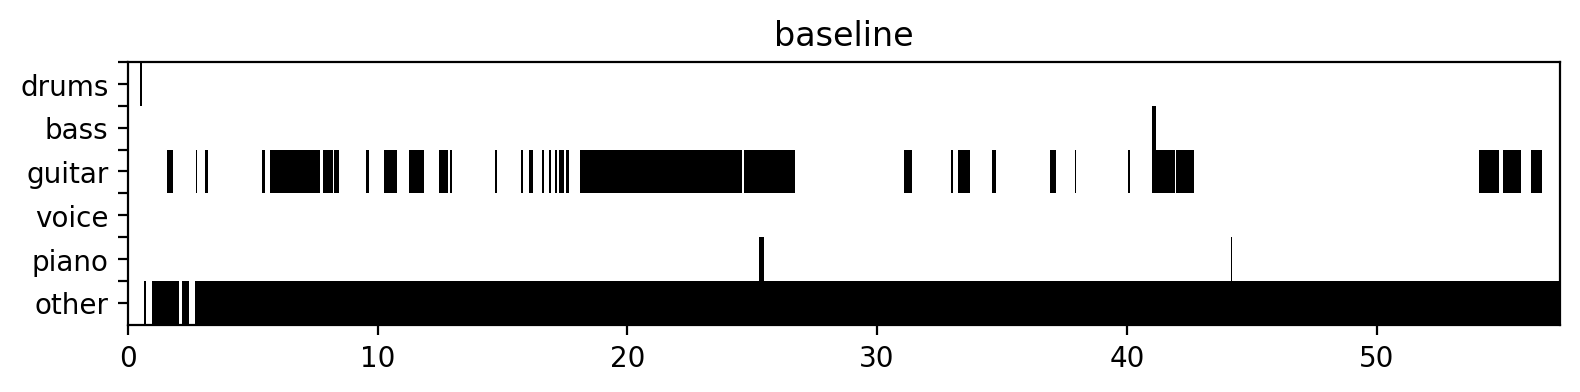

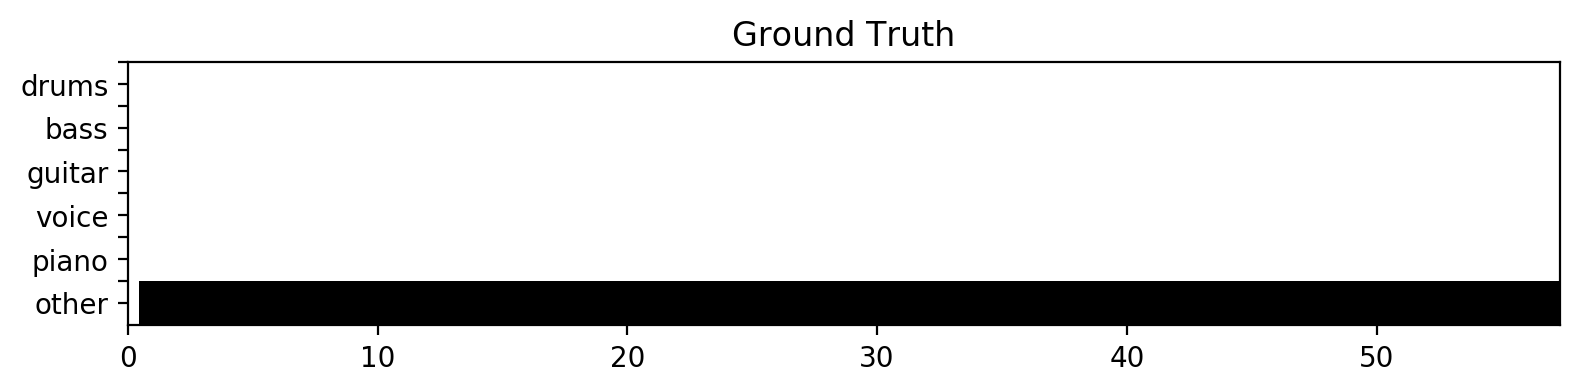

Loading..
Done..


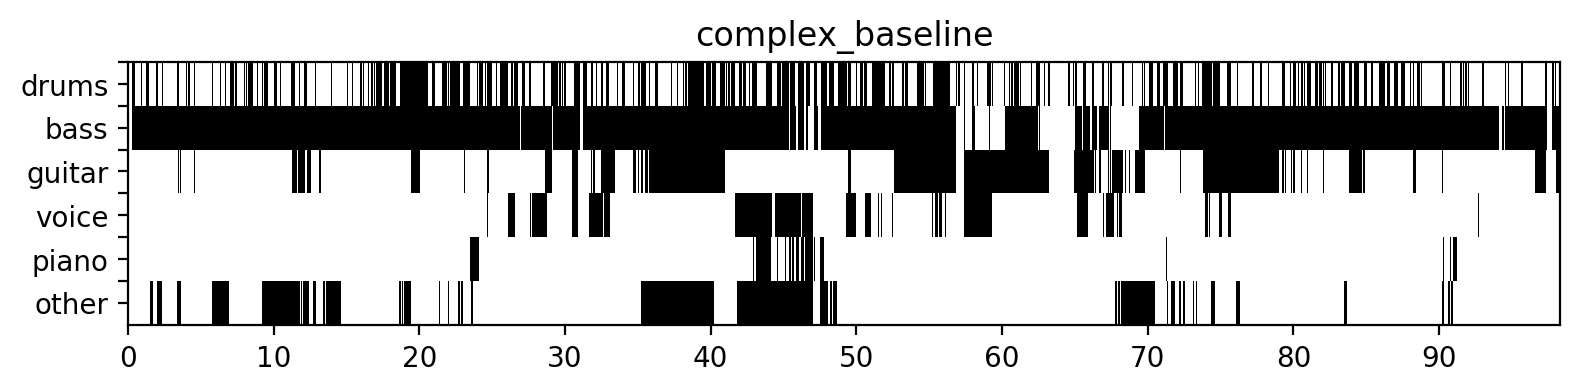

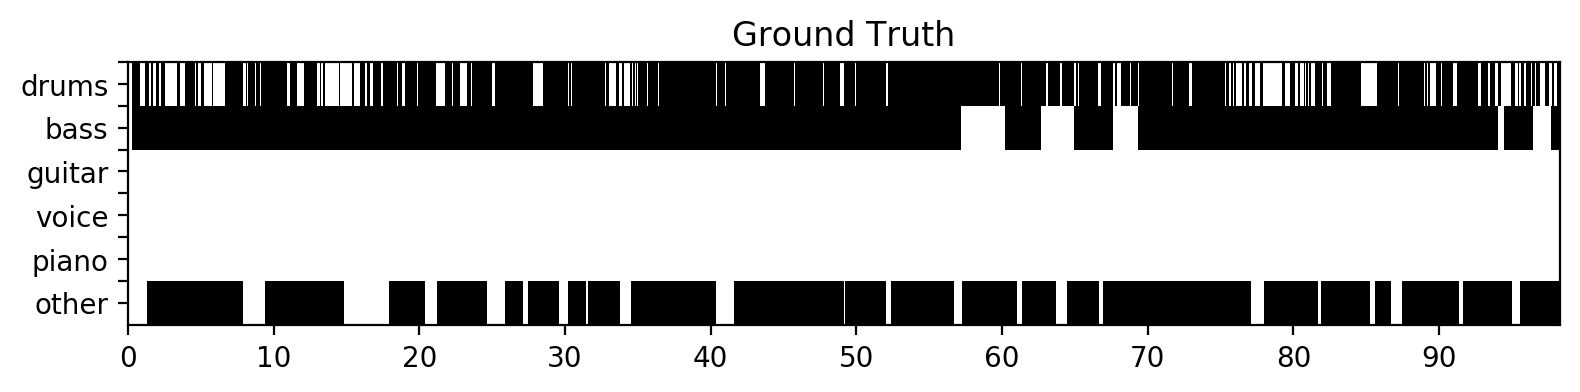

Loading..
Done..


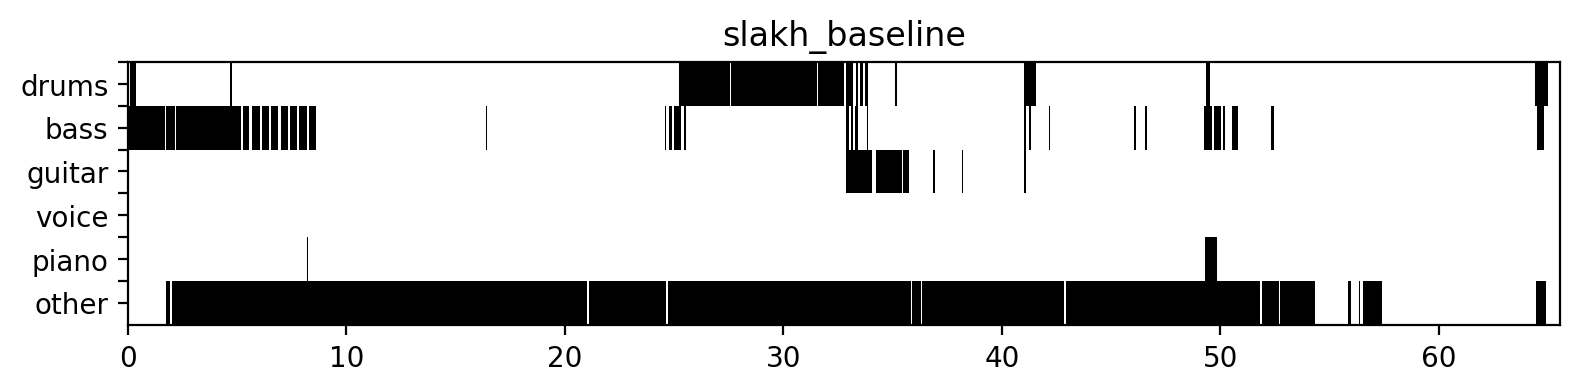

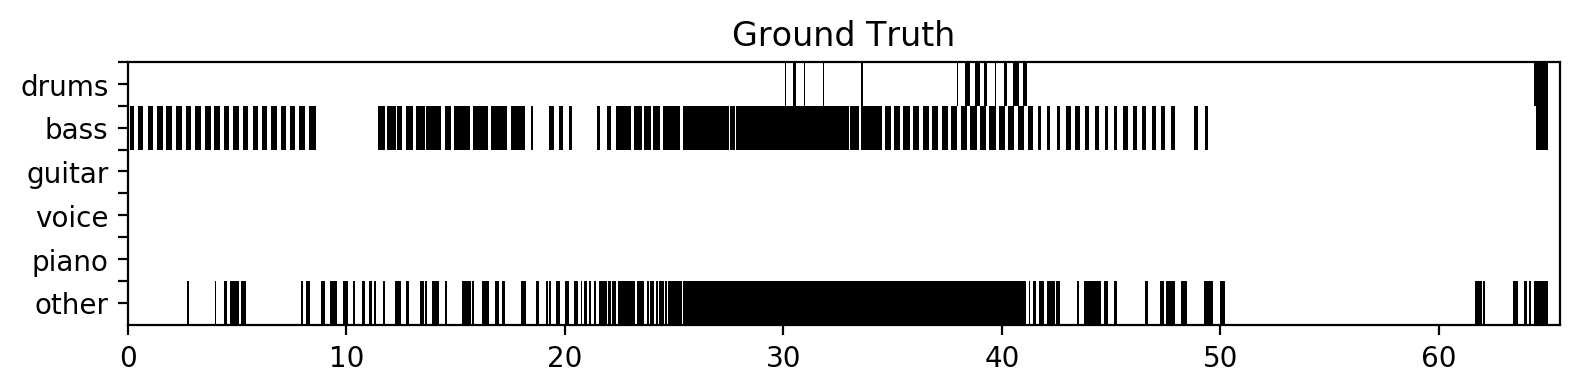

Loading..
Done..


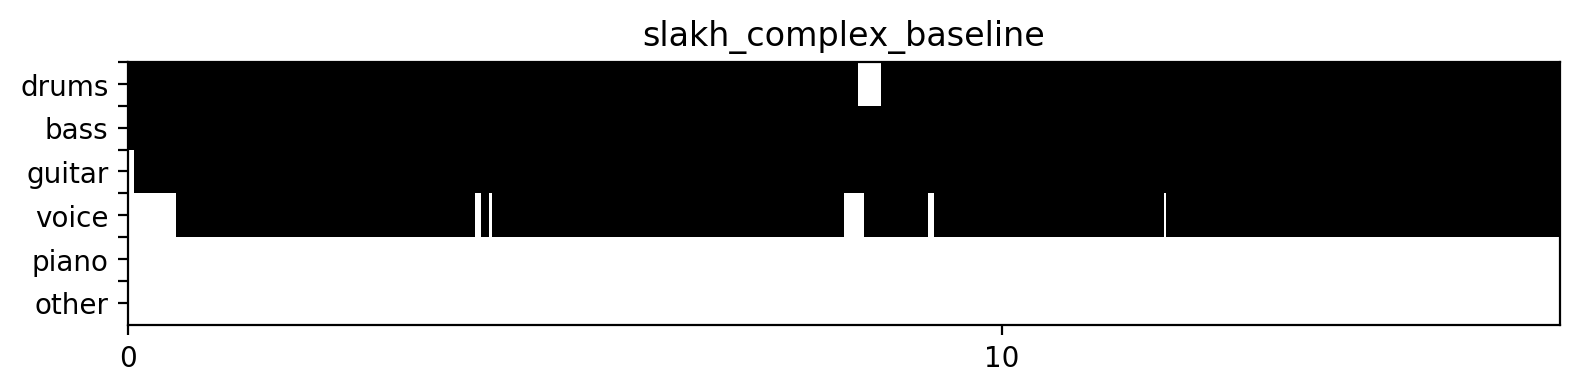

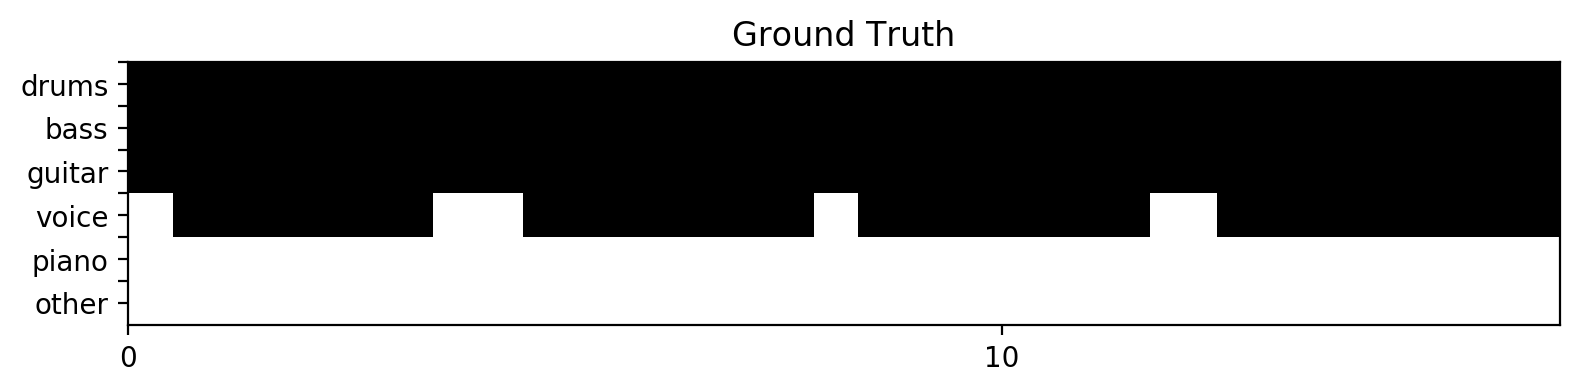

Loading..
Done..


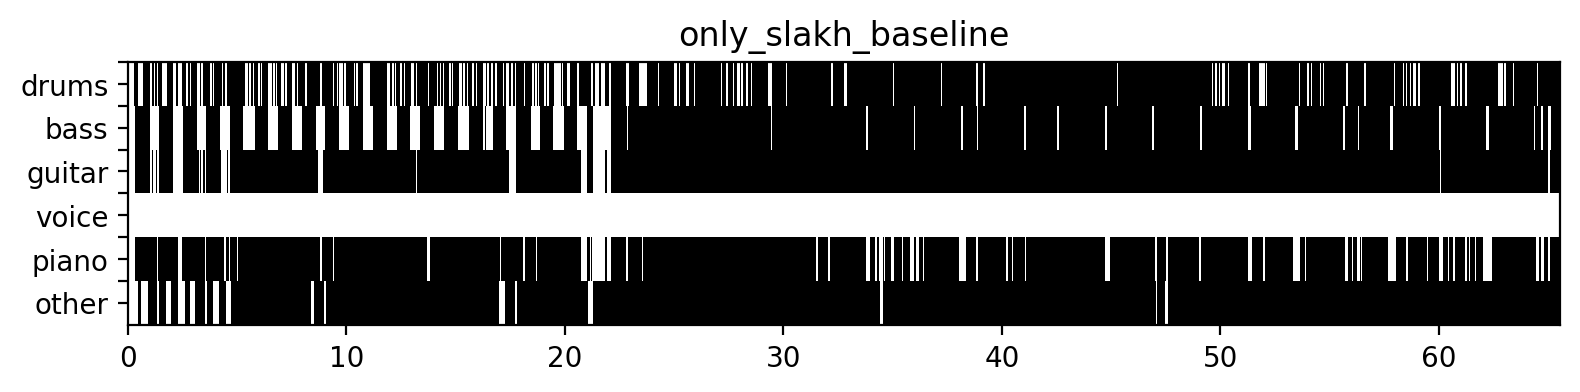

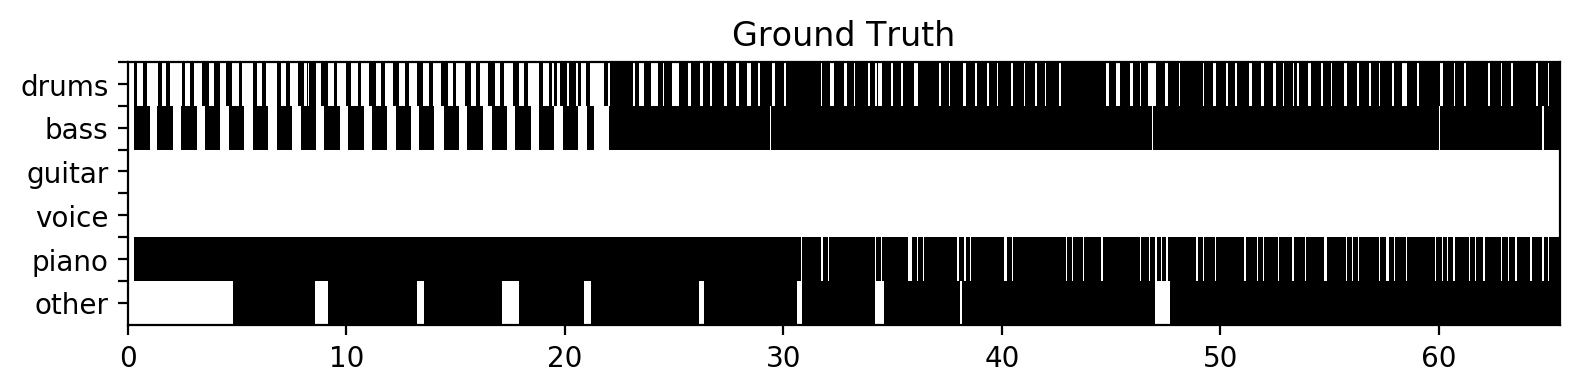

Loading..
Done..


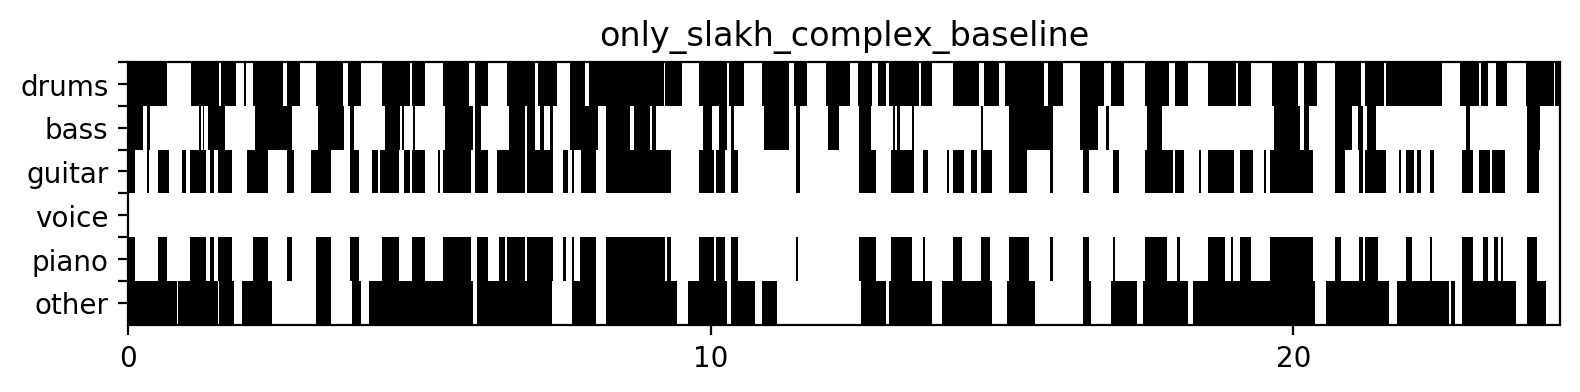

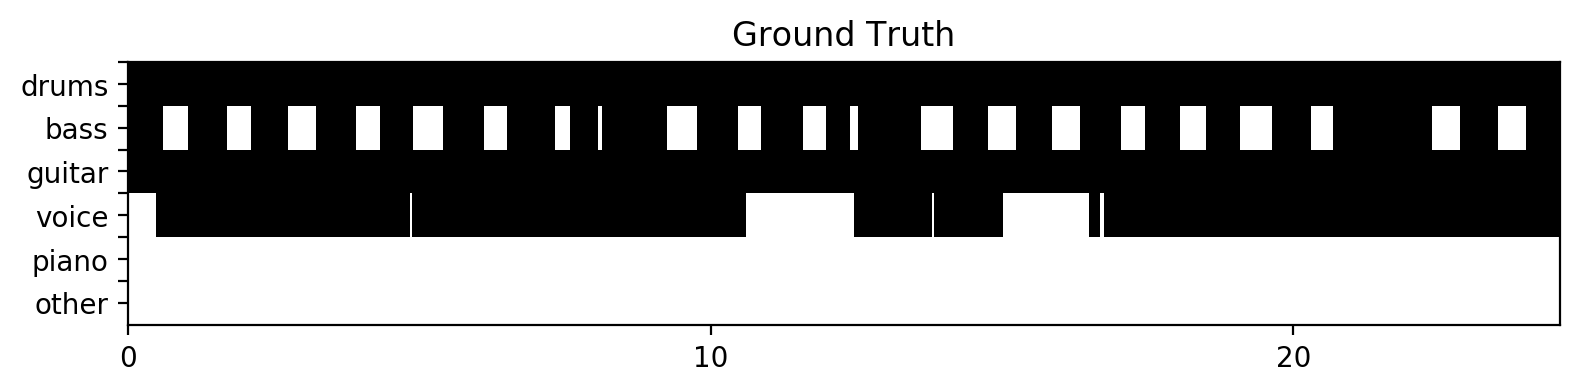

Loading..
Done..


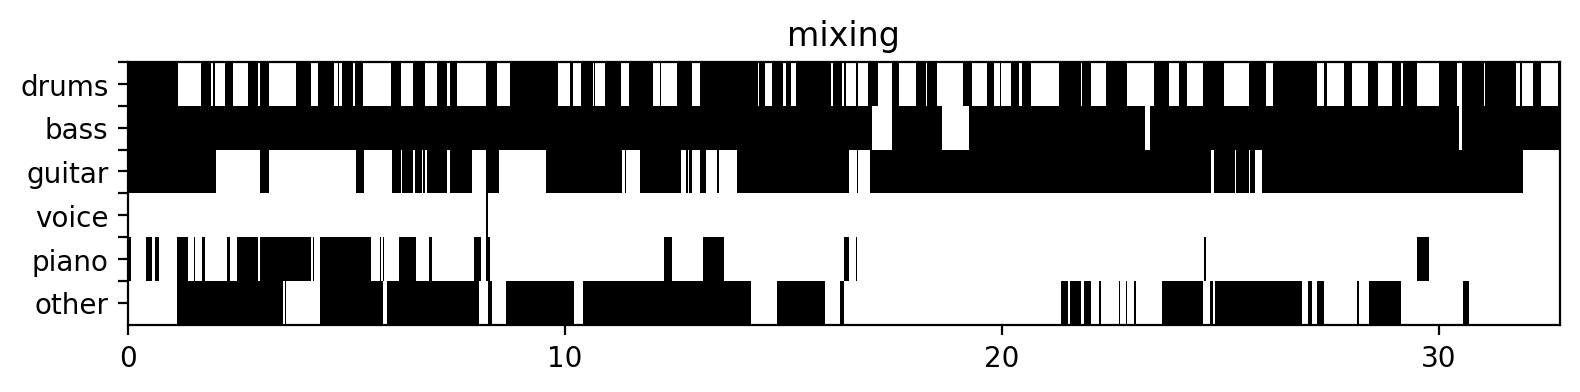

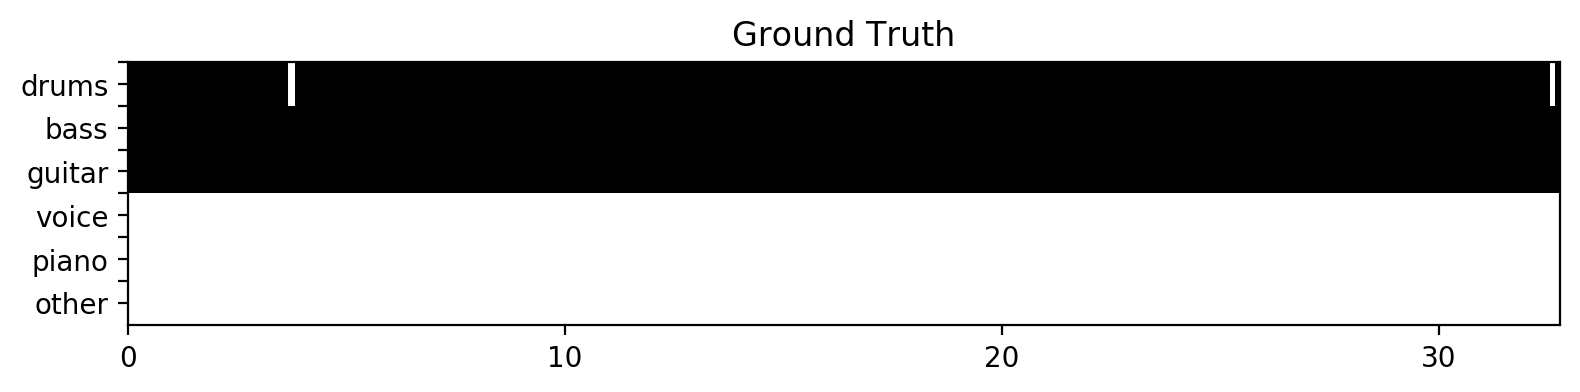

Loading..
Done..


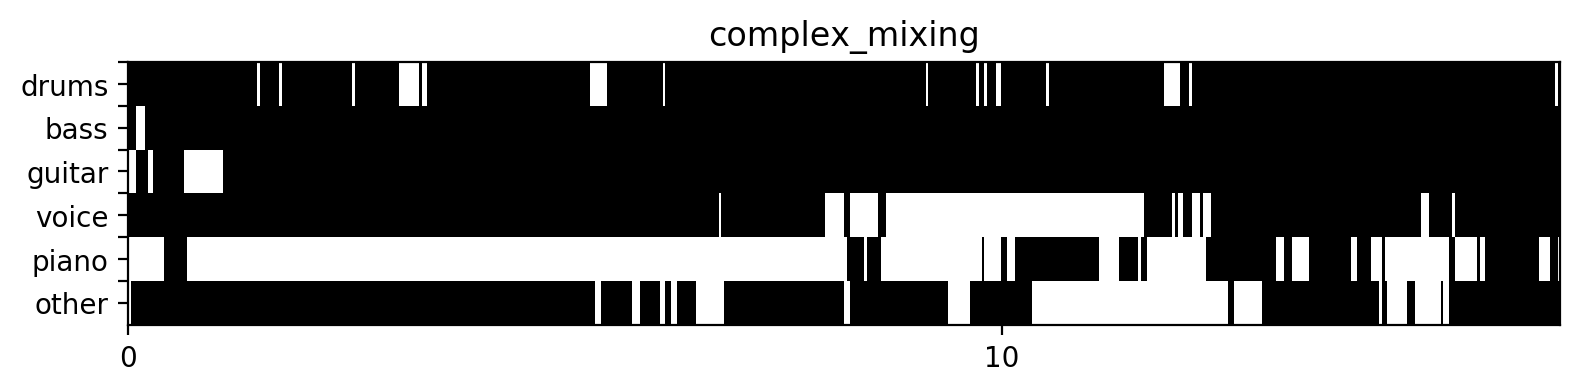

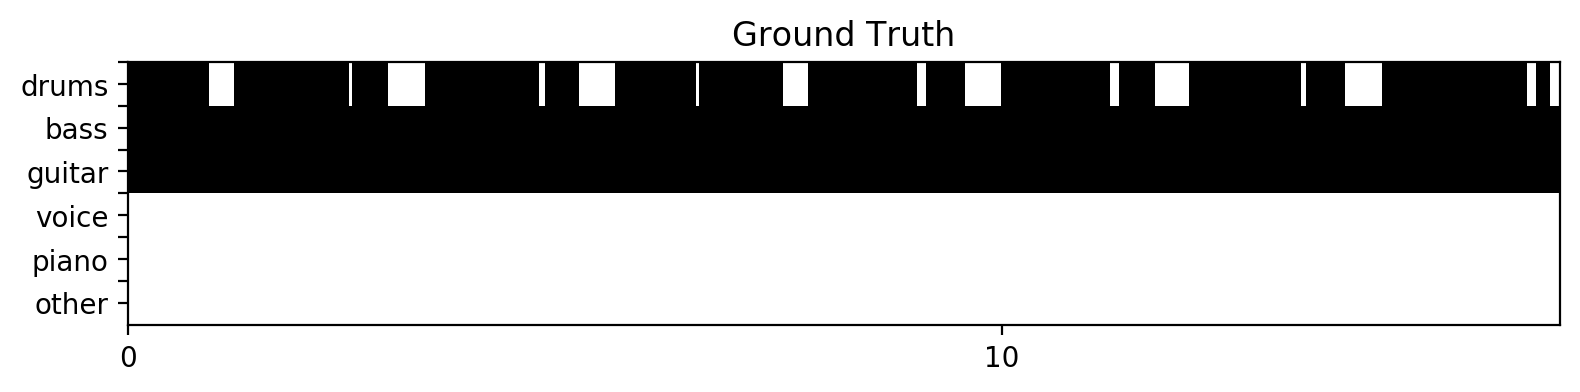

Loading..
Done..


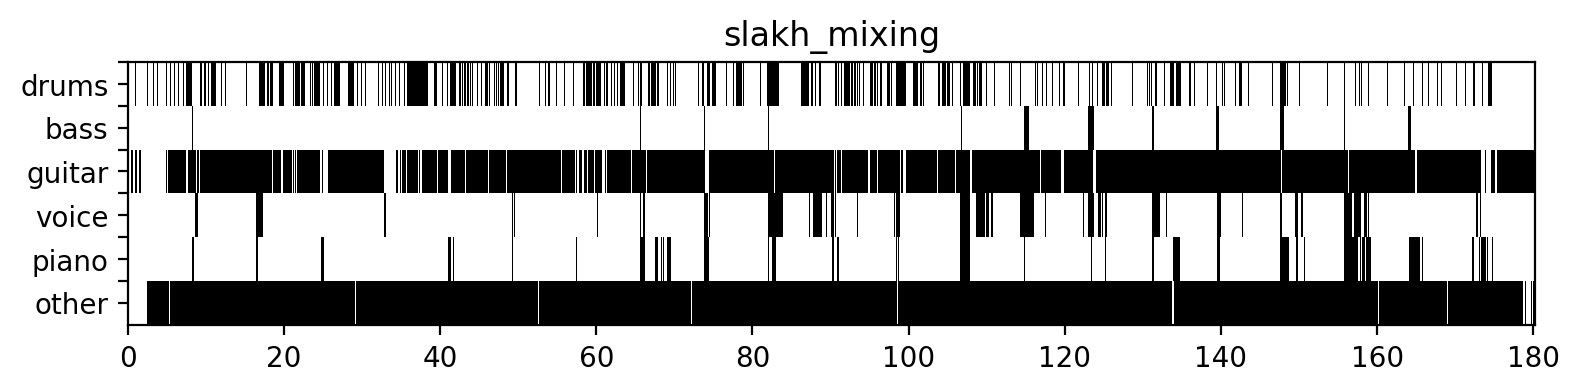

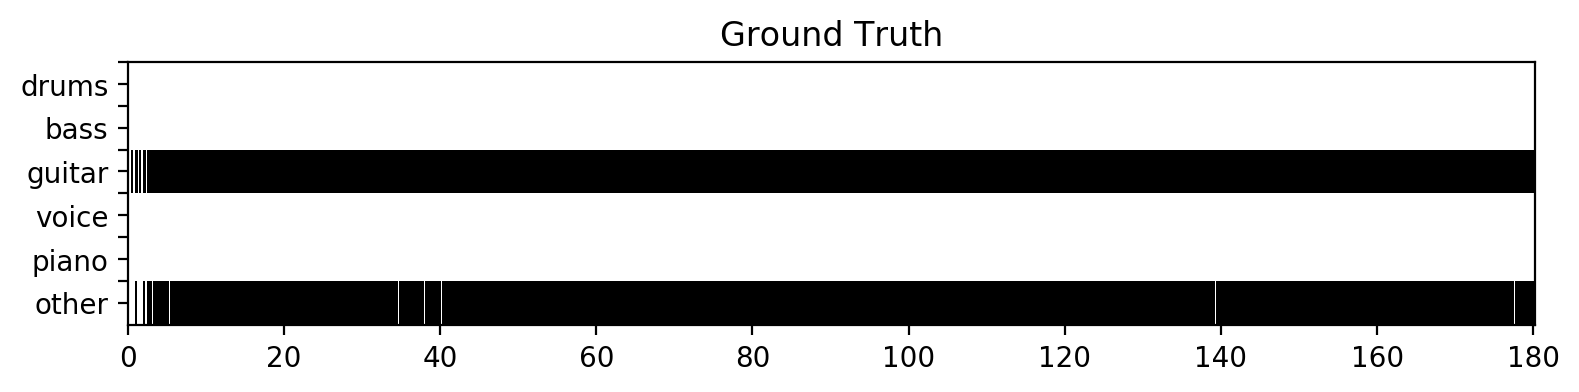

Loading..
Done..


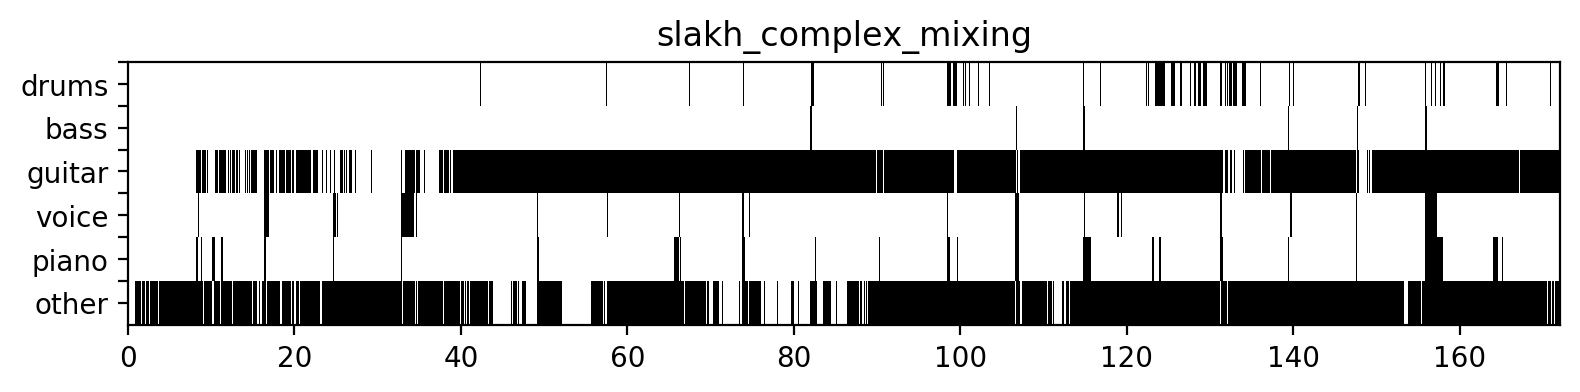

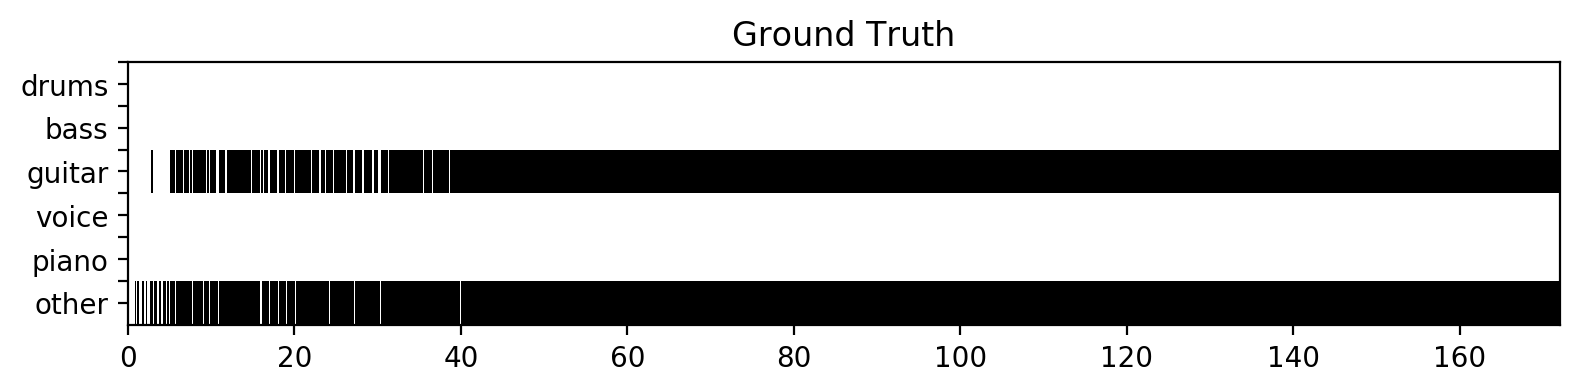

Loading..
Done..


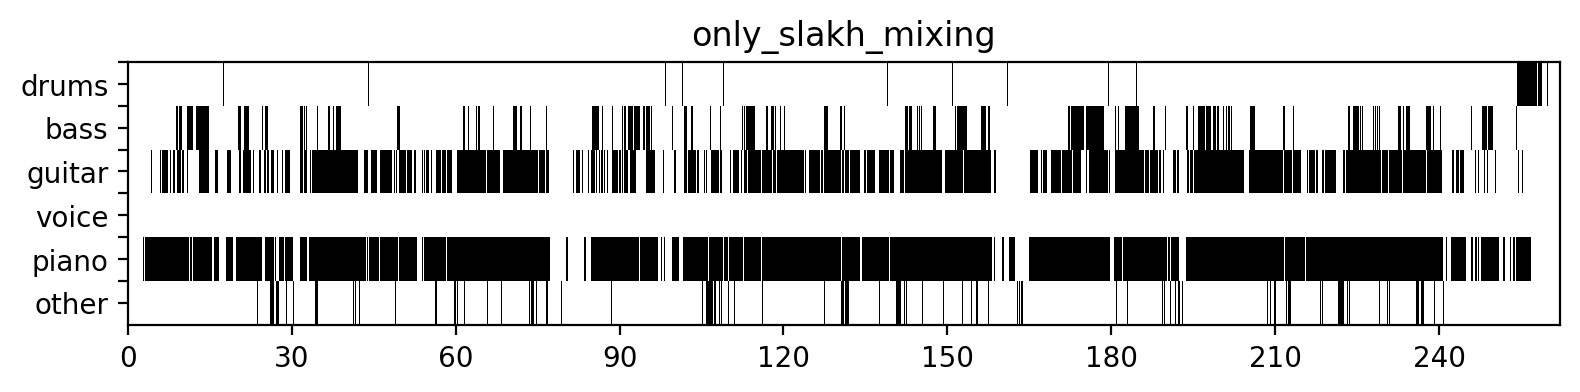

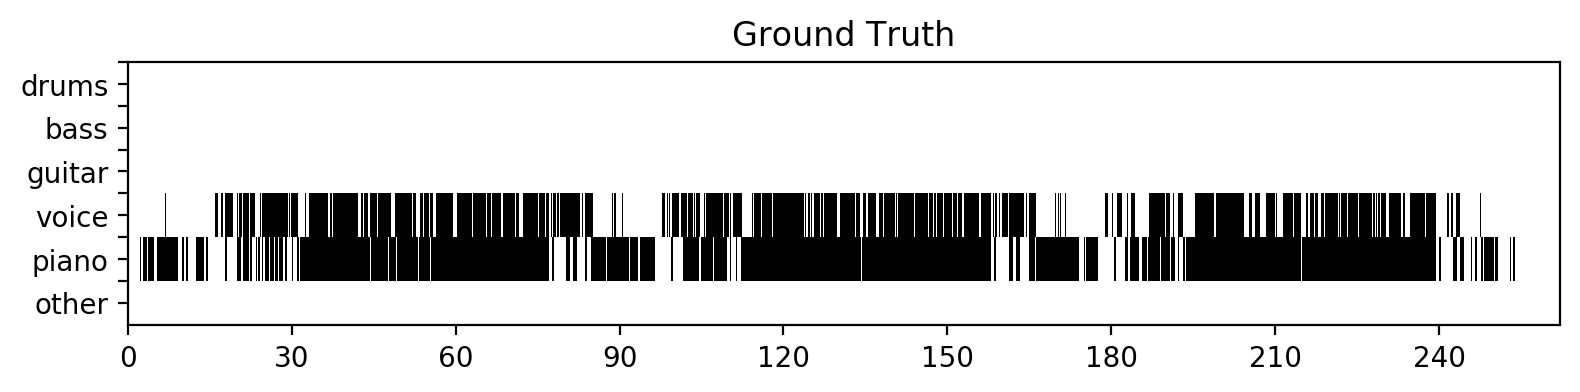

Loading..
Done..


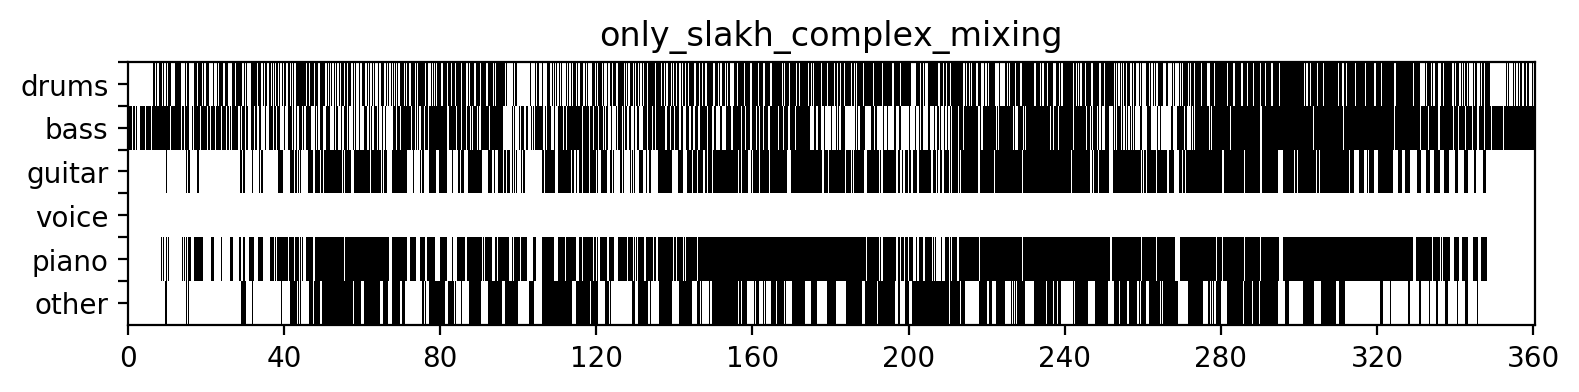

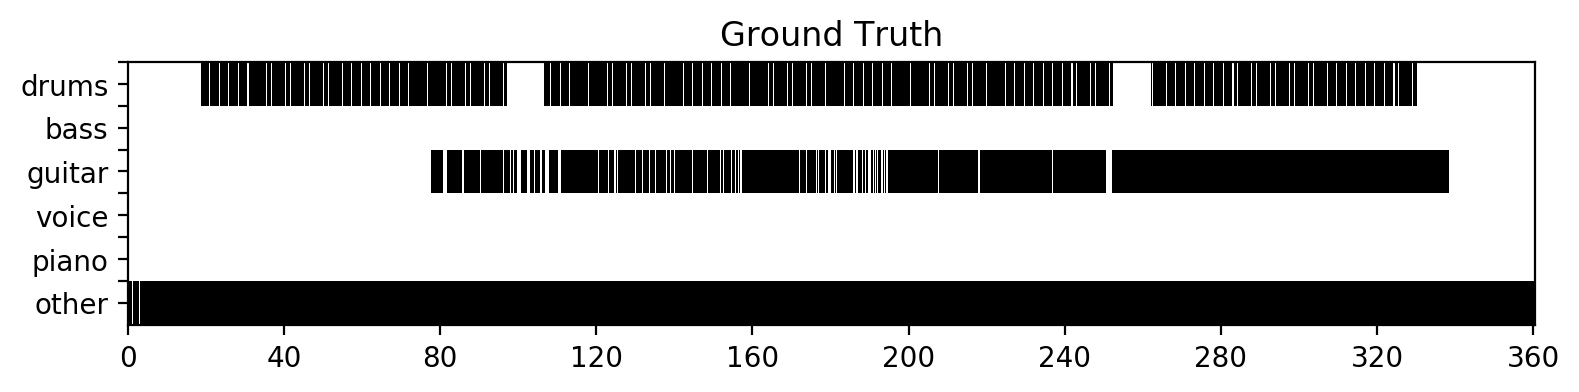

In [188]:
# state = {
#       "model_name": model_name,
#       "epoch": epoch + 1,
#       "lr": lr,
#       "train_losses": train_losses,
#       "validation_losses": validation_losses,
#       "state_dict": model.state_dict(),
#       "best_val_acc": validation_loss,
#       "optimizer": optimizer.state_dict(),
#       "metrics"
#   }

# https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
#%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams['figure.dpi'] = 200

#models = [
#    "pytorch_models/100_epoch_baseline_all_data",
#    "pytorch_models/100_epoch_complex_baseline_all_data",
#    "mixing",
#    "pytorch_models/100_epoch_complex_mixing_all_data",
#]

models = [
    "baseline",
    "complex_baseline",
    "slakh_baseline",
    "slakh_complex_baseline",
    "only_slakh_baseline",
    "only_slakh_complex_baseline",
    "mixing",
    "complex_mixing",
    "slakh_mixing",
    "slakh_complex_mixing",
    "only_slakh_mixing",
    "only_slakh_complex_mixing"
]

overfit_models = [
    "overfit_baseline",
    "overfit_complex_baseline",
    "overfit_slakh_baseline",
    "overfit_slakh_complex_baseline",
    "overfit_only_slakh_baseline",
    "overfit_only_slakh_complex_baseline",
    "overfit_mixing",
    "overfit_complex_mixing",
    "overfit_slakh_mixing",
    "overfit_slakh_complex_mixing",
    "overfit_only_slakh_mixing",
    "overfit_only_slakh_complex_mixing"
]

def plot_training(models):
    fig = plt.figure()
    n_rows = len(models)//2
    for i in range(len(models)):
        plt.subplot(n_rows, 2, i + 1)
        plt.plot(models[i]["train_losses"])
        plt.plot(models[i]["validation_losses"])
        plt.ylim(0,0.8)
        plt.title(models[i]["model_name"])

    plt.tight_layout()
    plt.show()
    fig.savefig("training_plots.pdf", bbox_inches='tight')


def plot_metrics(models):
    data = []
    model_names = []
    labels = ["F1-Macro", "F1-Micro", "LRAP", "AUC-ROC-Macro", "AUC-ROC-Micro"]

    for i in range(len(models)):
        model_data = []
        model_data.append(models[i]["metrics"]["macro avg"]["f1-score"])
        model_data.append(models[i]["metrics"]["macro avg"]["f1-score"])
        model_data.append(models[i]["metrics"]["lrap"])
        model_data.append(models[i]["metrics"]["auc_roc_macro"])
        model_data.append(models[i]["metrics"]["auc_roc_micro"])
        model_names.append(models[i]["model_name"])
        data.append(model_data)

    fig, ax = plt.subplots()
    X = np.arange(len(data[0]))
    for i in range(len(models)):
        width = (1 - 0.2) / len(models)
        ax.bar(X + width * i, data[i], width=width, label=model_names[i])

    plt.plot(data[0][0])
    ax.set_ylabel("Scores")
    ax.set_title("Metrics")
    x_ticks = []
    ax.set_xticks(X)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(0, 1, 0.1))
    #ax.legend(loc=2)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
              ncol=2, fancybox=True, shadow=True)

    plt.show()
    fig.savefig("metrics_plot.pdf", bbox_inches='tight')

def compare_models(models):
    loaded_models = [load_state(m) for m in models]
    plot_metrics(loaded_models)
    plot_training(loaded_models)


# Load models and runs tests and saves metrics in state_dict
def calculate_metrics_of_models(models):
    for m in models:
        model = CRNN(gru_input=256, gru_hidden=256, gru_layers=1, complx=("complex" in m))
        model.cuda()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        run_tests(m, model, optimizer)

def print_metrics(models):
    loaded_models = [load_state(m) for m in models]
    model_metrics = {k : {"precision": [], "recall": []} for k, v in loaded_models[0]["metrics"].items()}
    print(model_metrics)
    for m in loaded_models:
        print(m["metrics"])
        for k, v in m["metrics"].items(): 
            if k != "lrap" and k != "auc_roc_macro" and k != "auc_roc_micro":
                model_metrics[k]["precision"].append(round(v["precision"],3))
                model_metrics[k]["recall"].append(round(v["recall"],3))
    print(json.dumps(model_metrics, indent=4))
    
    
        
def print_classification_report(models):
    loaded_models = [load_state(m) for m in models]
    for m in loaded_models:
        print("=" * 80)
        print(m["model_name"])
        print(json.dumps(m["metrics"], indent=4))
        print("=" * 80)
        

whole_song_data = TestDB(test_paths, spectrogram_params, slakh)


def plot_iads(models):
    %matplotlib inline
    plt.rcParams["figure.figsize"] = [8, 2]
    plt.rcParams['figure.dpi'] = 200
    for m in models:
        whole_song = DataLoader(whole_song_data, batch_size=1, shuffle=False)
        data_gen = iter(whole_song)
        model = CRNN(gru_input=256, gru_hidden=256, gru_layers=1, complx=("complex" in m))
        model.cuda()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        test_model_on_song(m, model, optimizer, data_gen)
#print_classification_report(overfit_models)
#calculate_metrics_of_models(["overfit_only_slakh_baseline", "overfit_only_slakh_complex_baseline", "overfit_only_slakh_mixing", "overfit_only_slakh_complex_mixing"])
#compare_models(models)
#compare_models(overfit_models)
#print_classification_report(models)
#print_metrics(overfit_models)
plot_iads(models)
